# TopoLearn

In [ ]:
import seaborn as sns
import pandas as pd
import shap
from pathlib import PurePath
from matplotlib import rc
from evaluation import Validation
from plotting import get_palettes
from utils import get_column_name_mapping

%load_ext autoreload
%autoreload 2
rc('text', usetex=False) 
shap.initjs()

PROCESSED_DIR = PurePath("../topolearn/processed_data")
df = pd.read_csv(PROCESSED_DIR / "results.csv")
print(df.shape)

### Feature columns

In [ ]:
# Load plotting utils
representation_colors, dataset_colors = get_palettes()
col_name_mapping = get_column_name_mapping(df)


# Prepare feature columns
lifetime_cols = [col for col in df.columns if (
    "life" in col) and (not "train" in col)]
lifetime_cols_train = [col for col in df.columns if (
    "life" in col) and ("train" in col)]

topo_props = ["b_0", "b_1", "b_0_norm", "b_1_norm", "ph_entr_0", "ph_entr_1"]
topo_props_train = [f"{col}_train" for col in topo_props]

dim_cols = ["pca_dim", "twonn_dim", "ph_dim_0", "ph_dim_1"]
dim_cols_train = [f"{col}_train" for col in dim_cols]

modelability = ["rogi_xd", "rmodi", "sari"]
modelability_train = [f"{col}_train" for col in modelability]

other_props = ['n_estimators', 'learning_rate_init',
               'max_depth', 'max_iter', 'batch_size', "samples", "sample_dim"]
one_hot_cols = ["model", "hidden_layer_sizes",
                "activation", "early_stopping", "distance_metric"]
one_hot_dummies = []
target = "Relative RMSE"

for col in one_hot_cols:
    if df[col].dtype == "object":
        dummies = pd.get_dummies(df[col].apply(pd.Series))
        dummies.columns = [col + "_" + str(c) for c in dummies.columns]
        print("Added one-hot features for: ", col)
        one_hot_dummies += list(dummies.columns)
        df = pd.concat([df, dummies], axis=1)
        one_hot_cols = []


# Pre-define feature sets
ph_features = topo_props + lifetime_cols
all_features = dim_cols + topo_props + \
    lifetime_cols + other_props + one_hot_dummies
all_features_train = dim_cols_train + topo_props_train + \
    lifetime_cols_train + other_props + one_hot_dummies
all_features_w_modelability = dim_cols + topo_props + \
    lifetime_cols + other_props + one_hot_dummies + modelability

In [ ]:
def run_evaluation(feature_cols, feature_name, target_col, split="scaffold", loo_group=["dataset"],
                   distance_type={"all": None}, hue="representation", samples={"gte": 500}):

    if isinstance(distance_type, dict):
        dist = "all"
    else:
        dist = distance_type
    filename_suffix = f"{feature_name}_{target_col}_{split}_{dist}_{loo_group[0]}"

    palette_1 = representation_colors if hue == "representation" else dataset_colors
    palette_2 = dataset_colors if hue == "representation" else representation_colors

    validator = Validation(df, loo_group=loo_group, split=split, samples=samples,
                           distance_type=distance_type, target_col=target_col, representation={
                               "all": None},
                           feature_cols=feature_cols)
    validator.run_LOGO_CV(plot_hue=hue, plot_intermediate=False)
    validator.plot_predictions_grid(method="TopoLearn", hue=hue, palette=palette_1, n_cols=4,
                                    save_file=f"topolearn_{filename_suffix}", alpha=0.8, markeredgecolor="black",
                                    markeredgewidth=0.5, size_div=30, bbox_to_anchor=(1, 0.5), figsize=(15, 4))

    validator.plot_summary(hue=hue, palette=palette_1, save_file=f"topolearn_summary_{filename_suffix}",
                           alpha=0.5, size_div=35, figsize=(15, 4), ncols=2, markeredgecolor="black",
                           markeredgewidth=0.5)

    validator.plot_shap_grid(figsize=(
        15, 3), n_cols=3, save_file=f"shap_{filename_suffix}", col_name_mapping=col_name_mapping)

    validator.plot_feature_importances(hue=loo_group[0], palette=palette_2,
                                       save_file=f"featimp_{filename_suffix}", alpha=0.8, bar_fill=True, s=10,
                                       bar_color="lightgrey", bar_line_color="black", bar_linewidth=1.2, col_name_mapping=col_name_mapping)
    return validator.evaluation_table(filename=f"../topolearn/processed_data/correlations/corr_{filename_suffix}")

### Inference models

In [ ]:
run_evaluation(ph_features,
               "topo",
               target,
               split="random",
               loo_group=["dataset"],
               distance_type={"all": None},
               hue="representation",
               samples={"gte": 500})

In [ ]:
run_evaluation(ph_features,
               "topo",
               target,
               split="scaffold",
               loo_group=["dataset"],
               distance_type={"all": None},
               hue="representation",
               samples={"gte": 500})

### Evaluations

In [ ]:
run_evaluation(all_features,
               "all",
               target,
               split="random",
               loo_group=["dataset"],
               distance_type={"all": None},
               hue="representation",
               samples={"gte": 500})

## Scaffold split

### Evaluation 1:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | scaffold  |
| Distance | all |
| Features | all except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               target,
               split="scaffold",
               loo_group=["dataset"],
               distance_type={"all": None},
               hue="representation",
               samples={"gte": 500})

### Evaluation 2:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | scaffold  |
| Distance | all |
| Features | all on train except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features_train,
               "all_train",
               target,
               split="scaffold",
               loo_group=["dataset"],
               distance_type={"all": None},
               hue="representation",
               samples={"gte": 500})

### Evaluation 3:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | scaffold  |
| Distance | jaccard |
| Features | all except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               target,
               split="scaffold",
               loo_group=["dataset"],
               distance_type="jaccard",
               hue="representation",
               samples={"gte": 500})

### Evaluation 4:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | scaffold  |
| Distance | euclidean |
| Features | all except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               target,
               split="scaffold",
               loo_group=["dataset"],
               distance_type="euclidean",
               hue="representation",
               samples={"gte": 500})

### Evaluation 5:

| Setting    | Value |
| -------- | ------- |
| Leave out  | representation |
| Split | scaffold  |
| Distance | all |
| Features | all except modelability |
| Samples | all |
| Target | Relative RMSE |

In [23]:
run_evaluation(all_features,
               "all",
               target,
               split="scaffold",
               loo_group=["representation"],
               distance_type={"all": None},
               hue="dataset",
               samples={"gte": 500})

  0%|          | 0/26 [00:00<?, ?it/s]

Fold 0, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
  4%|▍         | 1/26 [04:02<1:40:58, 242.34s/it]

Fold 1, X train: 1275, X test: 51


  8%|▊         | 2/26 [08:14<1:39:12, 248.02s/it]

Fold 2, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 12%|█▏        | 3/26 [12:11<1:33:11, 243.10s/it]

Fold 3, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 15%|█▌        | 4/26 [13:55<1:09:03, 188.32s/it]

Fold 4, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 19%|█▉        | 5/26 [16:55<1:04:51, 185.33s/it]

Fold 5, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 23%|██▎       | 6/26 [18:42<52:52, 158.62s/it]  

Fold 6, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 27%|██▋       | 7/26 [22:34<57:47, 182.49s/it]

Fold 7, X train: 1275, X test: 51


 31%|███       | 8/26 [26:13<58:16, 194.24s/it]

Fold 8, X train: 1275, X test: 51


 35%|███▍      | 9/26 [29:53<57:15, 202.09s/it]

Fold 9, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 38%|███▊      | 10/26 [32:40<51:01, 191.32s/it]

Fold 10, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 42%|████▏     | 11/26 [35:23<45:42, 182.86s/it]

Fold 11, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 46%|████▌     | 12/26 [37:04<36:49, 157.83s/it]

Fold 12, X train: 1275, X test: 51


 50%|█████     | 13/26 [40:56<39:03, 180.26s/it]

Fold 13, X train: 1275, X test: 51


### Evaluation 6:

| Setting    | Value |
| -------- | ------- |
| Leave out  | representation |
| Split | scaffold  |
| Distance | all |
| Features | all on train except modelability |
| Samples | all |
| Target | Relative RMSE |

/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
  4%|▍         | 1/26 [03:59<1:39:45, 239.40s/it]

Fold 1, X train: 1275, X test: 51


  8%|▊         | 2/26 [06:47<1:19:04, 197.68s/it]

Fold 2, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 12%|█▏        | 3/26 [10:43<1:22:21, 214.85s/it]

Fold 3, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 15%|█▌        | 4/26 [14:38<1:21:40, 222.77s/it]

Fold 4, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 19%|█▉        | 5/26 [17:29<1:11:28, 204.24s/it]

Fold 5, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 23%|██▎       | 6/26 [21:25<1:11:40, 215.00s/it]

Fold 6, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 27%|██▋       | 7/26 [23:00<55:37, 175.66s/it]  

Fold 7, X train: 1275, X test: 51


 31%|███       | 8/26 [27:07<59:33, 198.54s/it]

Fold 8, X train: 1275, X test: 51


 35%|███▍      | 9/26 [31:01<59:25, 209.76s/it]

Fold 9, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 38%|███▊      | 10/26 [35:11<59:14, 222.15s/it]

Fold 10, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 42%|████▏     | 11/26 [36:51<46:08, 184.56s/it]

Fold 11, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 46%|████▌     | 12/26 [37:44<33:44, 144.61s/it]

Fold 12, X train: 1275, X test: 51


 50%|█████     | 13/26 [41:19<35:57, 165.99s/it]

Fold 13, X train: 1275, X test: 51


 54%|█████▍    | 14/26 [44:04<33:07, 165.60s/it]

Fold 14, X train: 1275, X test: 51


 58%|█████▊    | 15/26 [47:59<34:11, 186.54s/it]

Fold 15, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 62%|██████▏   | 16/26 [51:51<33:22, 200.22s/it]

Fold 16, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 65%|██████▌   | 17/26 [54:27<28:03, 187.10s/it]

Fold 17, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 69%|██████▉   | 18/26 [57:25<24:33, 184.19s/it]

Fold 18, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 73%|███████▎  | 19/26 [1:01:20<23:15, 199.35s/it]

Fold 19, X train: 1275, X test: 51


 77%|███████▋  | 20/26 [1:04:16<19:15, 192.53s/it]

Fold 20, X train: 1275, X test: 51


 81%|████████  | 21/26 [1:07:57<16:45, 201.01s/it]

Fold 21, X train: 1275, X test: 51


 85%|████████▍ | 22/26 [1:11:37<13:46, 206.63s/it]

Fold 22, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 88%|████████▊ | 23/26 [1:14:23<09:44, 194.68s/it]

Fold 23, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 92%|█████████▏| 24/26 [1:17:19<06:17, 188.94s/it]

Fold 24, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
 96%|█████████▌| 25/26 [1:21:31<03:27, 207.71s/it]

Fold 25, X train: 1275, X test: 51


/home/rottach/phd/notebooks/evaluation.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_res = sp.stats.pearsonr(y_pred, y_test)
/home/rottach/phd/notebooks/evaluation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_res = sp.stats.spearmanr(y_pred, y_test)
100%|██████████| 28/28 [00:02<00:00, 10.02it/s]


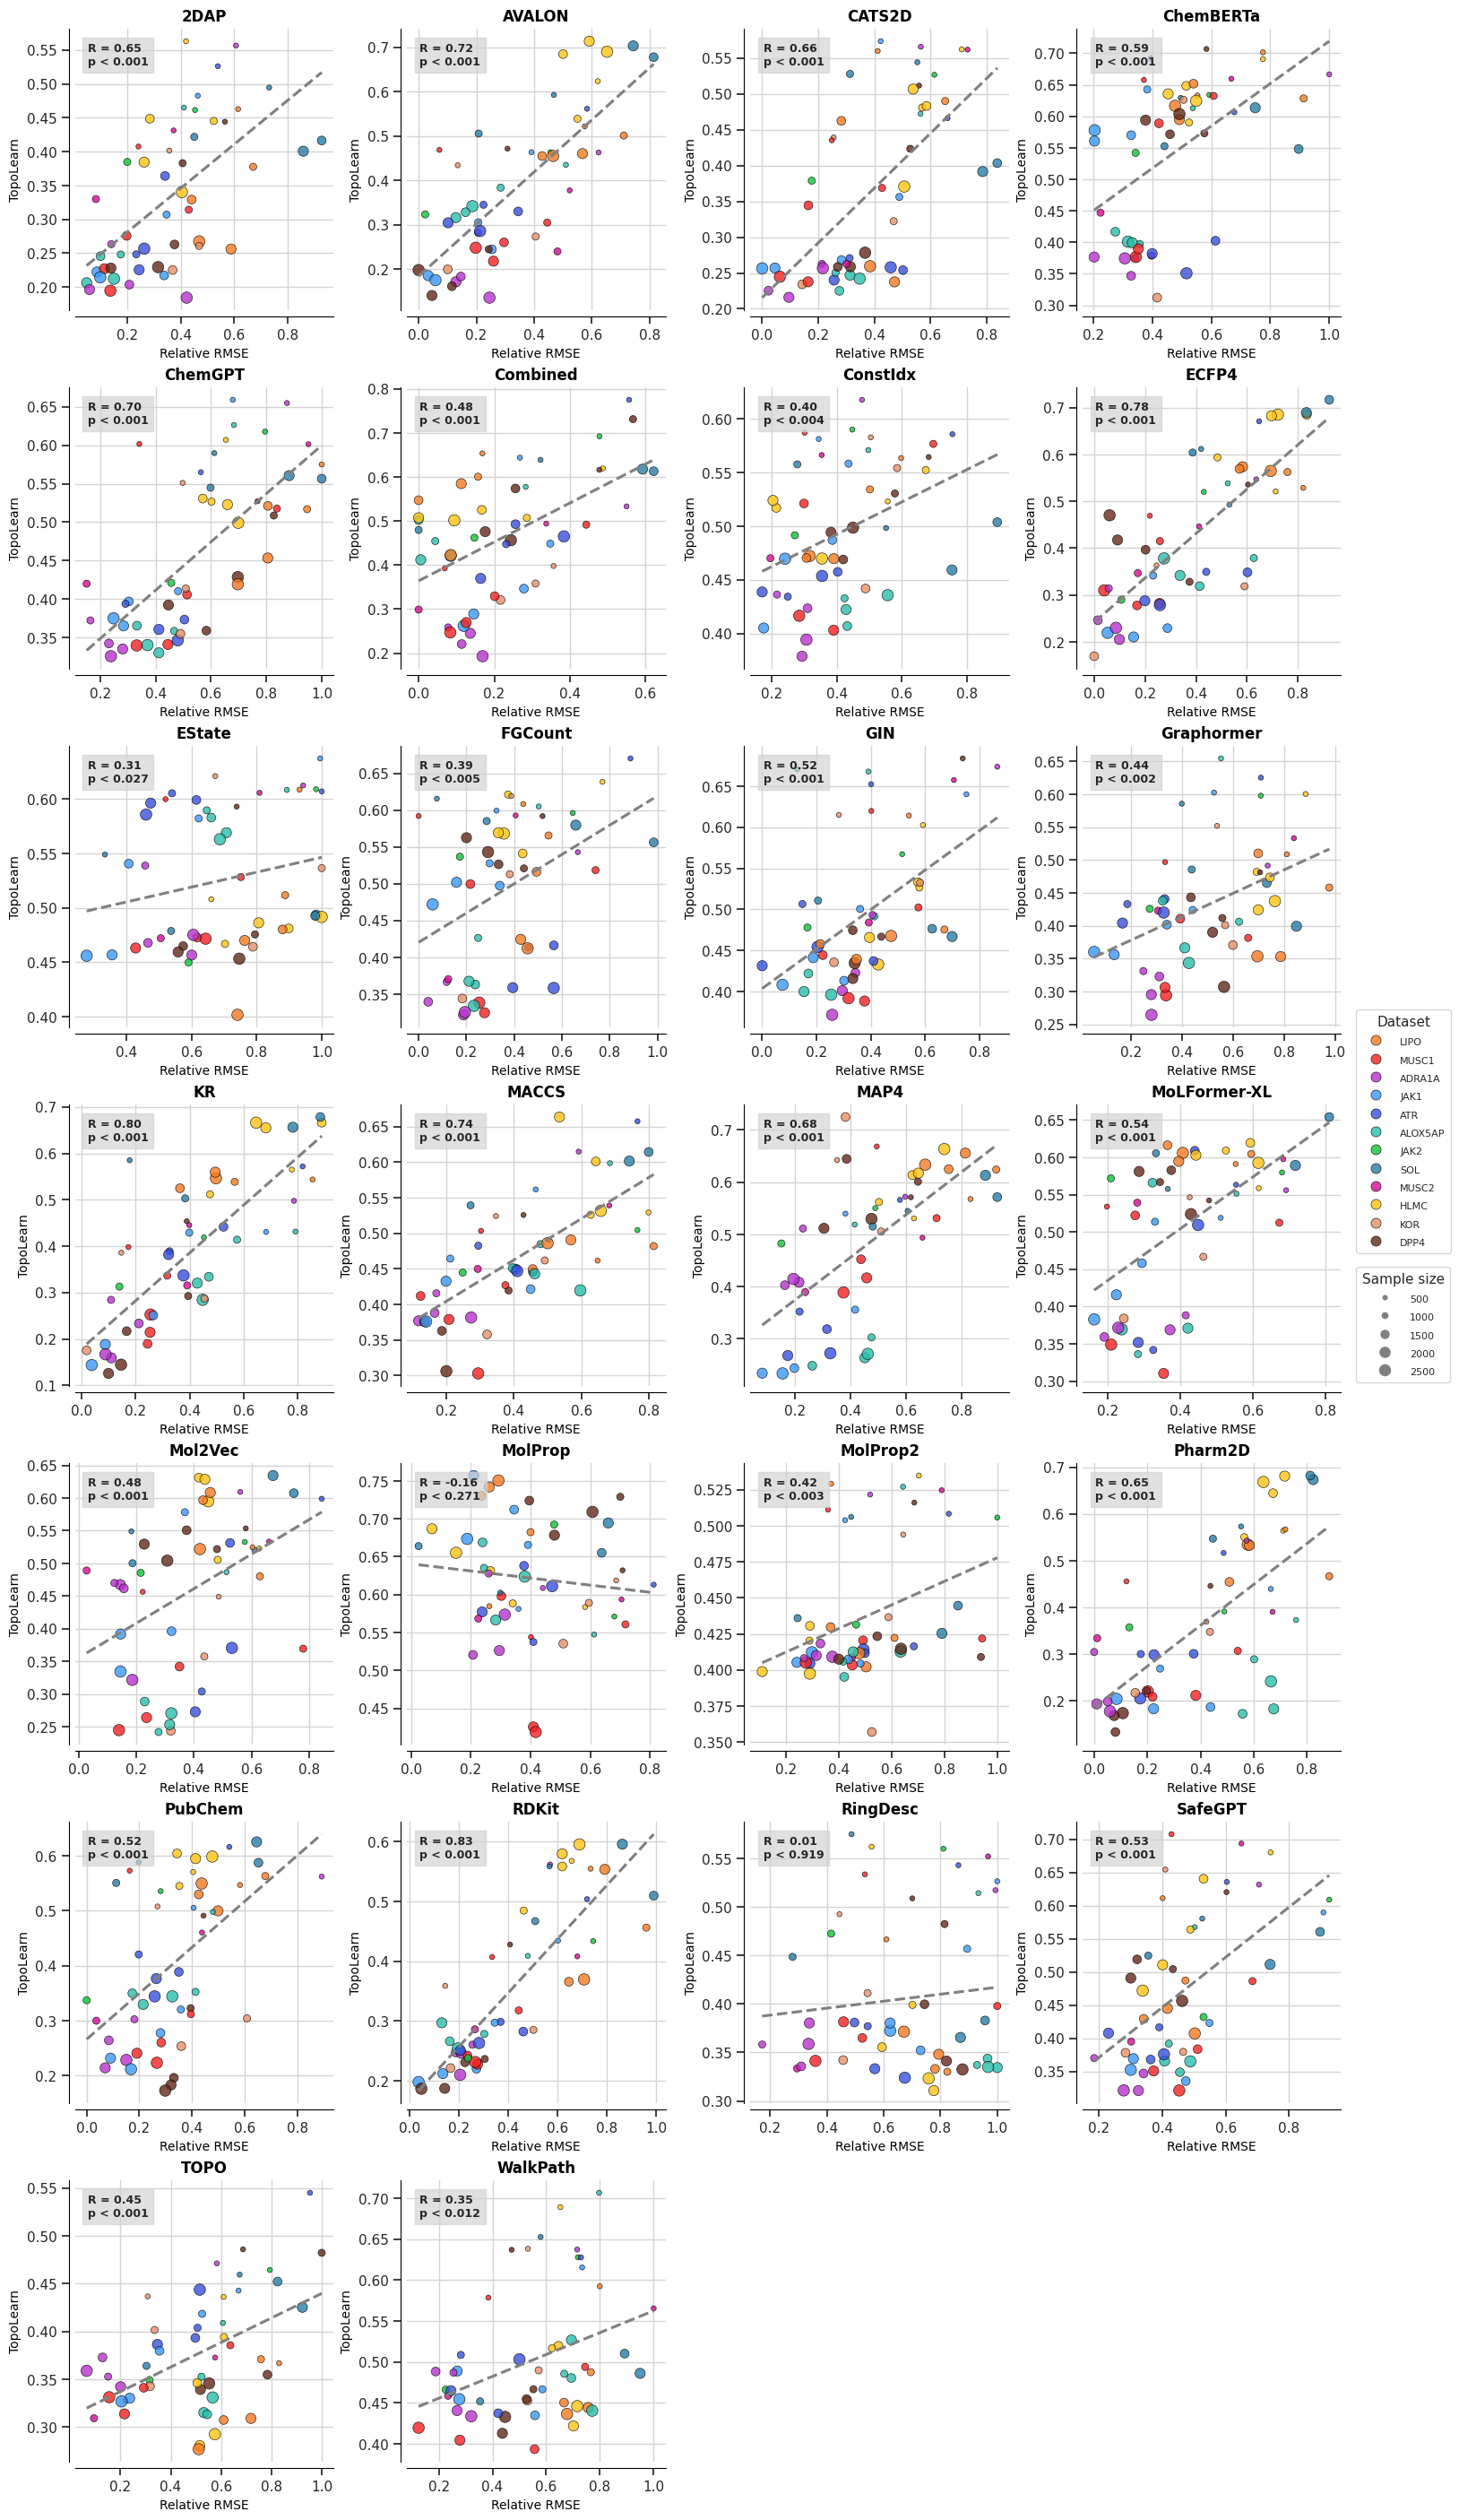

/home/rottach/phd/notebooks/evaluation.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_data[col][0] = results_data[col][0].tolist()
/home/rottach/phd/notebooks/evaluation.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_data[col][0] = results_data[col][0].tolist()
/home/rottach/phd/notebooks/evaluation.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_data[col][0] = results_data[col][0].tolist()
/

<Figure size 640x480 with 0 Axes>

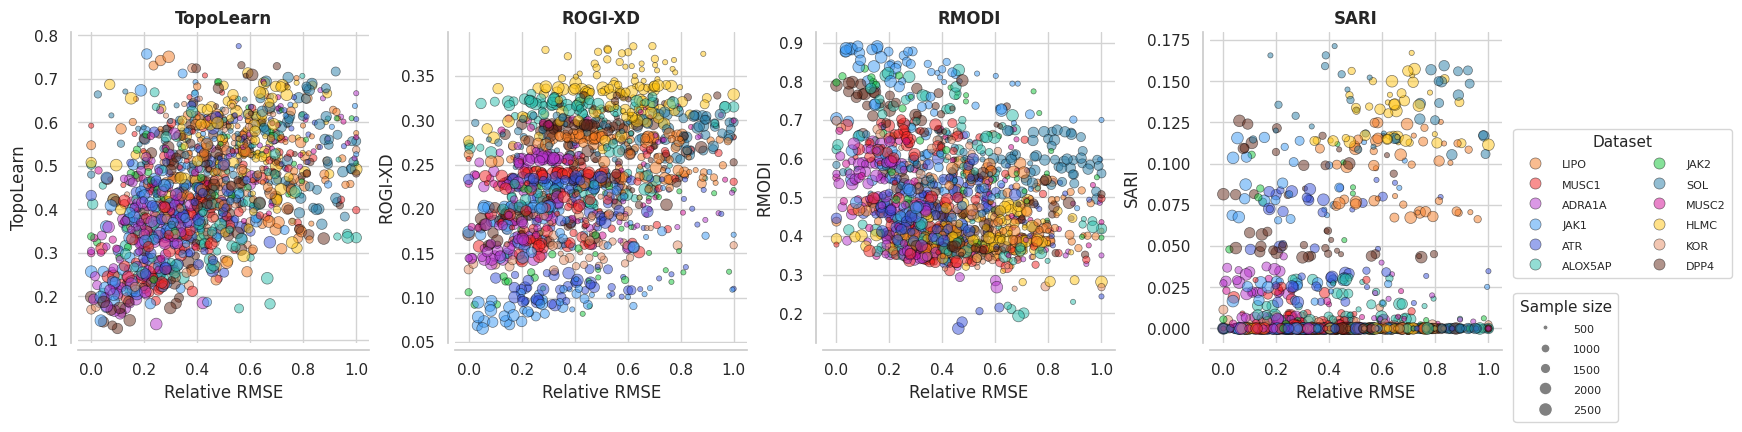

100%|██████████| 27/27 [1:04:31<00:00, 143.39s/it]


<Figure size 640x480 with 0 Axes>

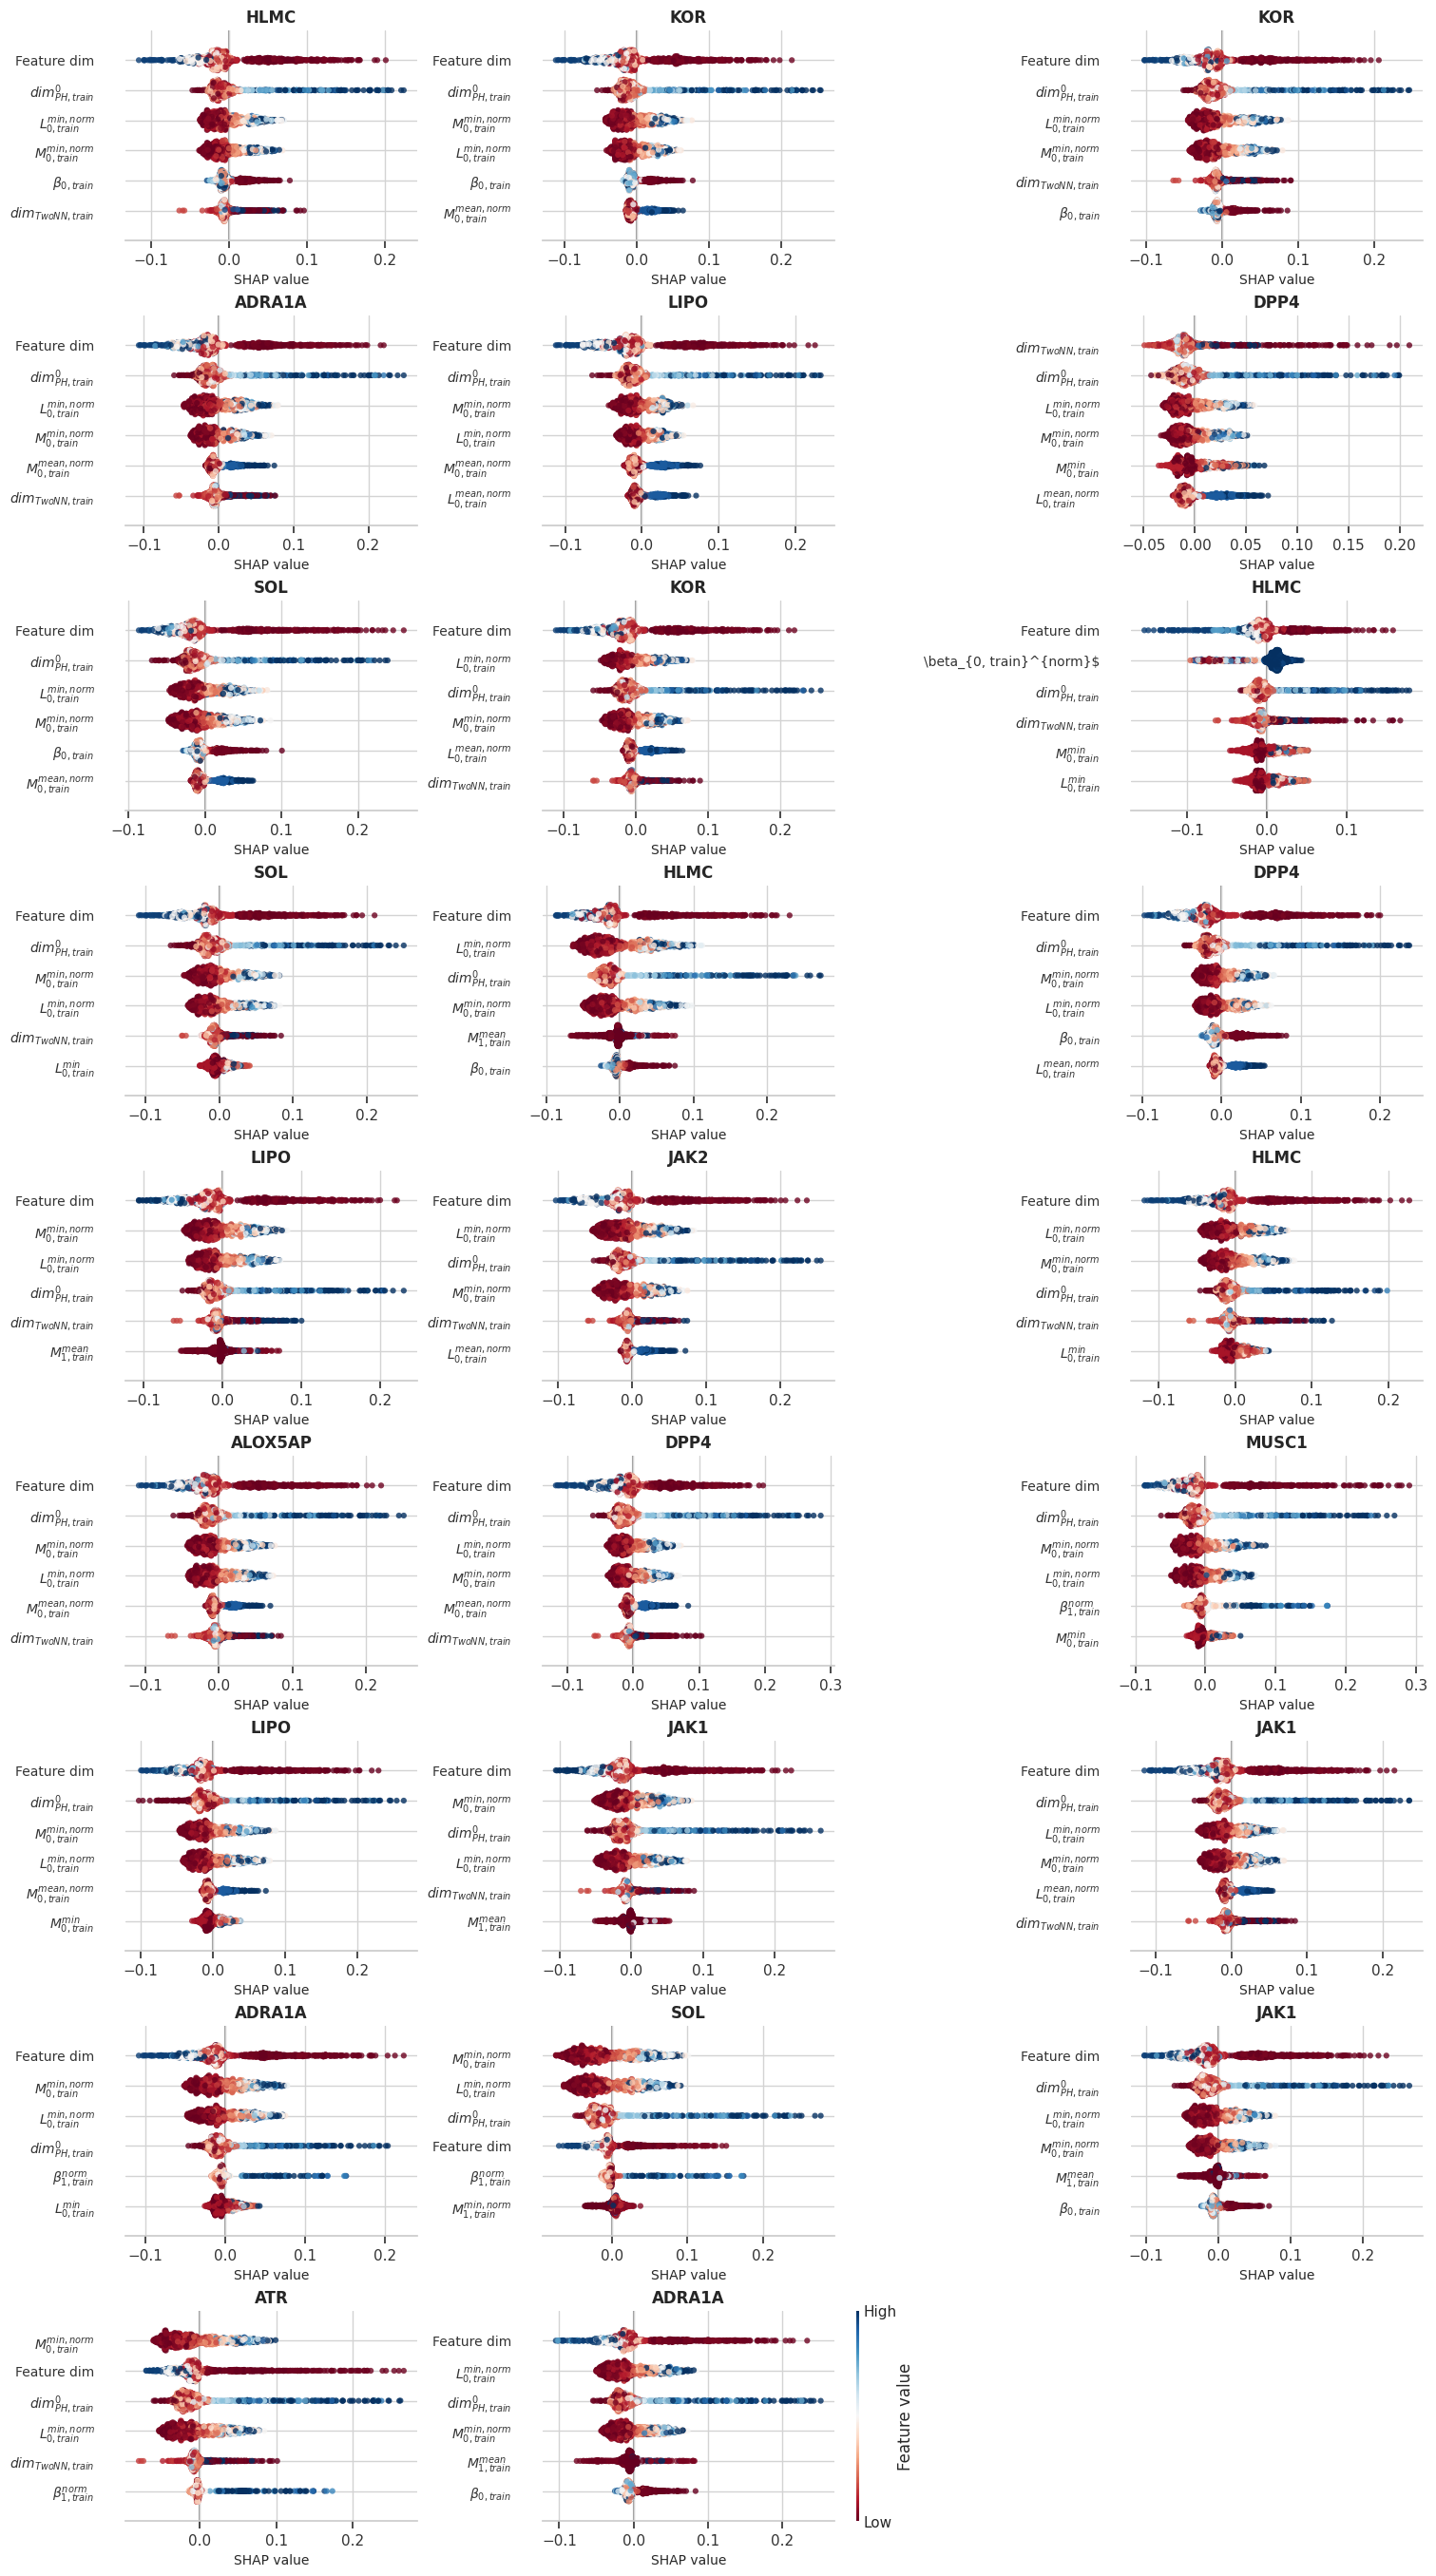

/home/rottach/phd/notebooks/evaluation.py:328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_yticklabels(


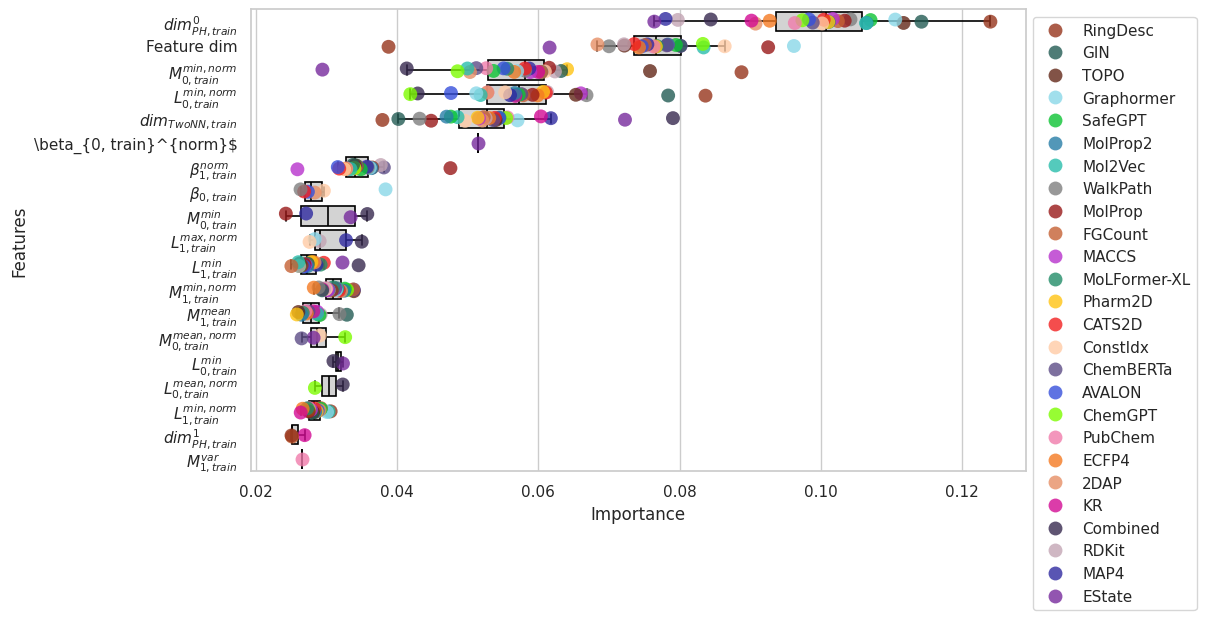

,Spearman,Pearson,MAE,spearman_all,spearman_p_all,pearson_all,pearson_p_all,mae_all
TopoLearn,0.52±0.22,0.52±0.22,0.16±0.05,0.477095,0.0,0.468256,0.0,0.159507
ROGI-XD,0.34±0.21,0.34±0.21,0.24±0.08,0.343388,0.0,0.331808,0.0,0.237486
RMODI,-0.17±0.20,-0.14±0.22,0.24±0.07,-0.255576,0.0,-0.272108,0.0,0.242969
SARI,nan±nan,nan±nan,0.42±0.11,0.006869,0.802668,0.122806,0.000007,0.423997


In [22]:
run_evaluation(all_features_train,
               "all_train",
               target,
               split="scaffold",
               loo_group=["representation"],
               distance_type={"all": None},
               hue="dataset",
               samples={"gte": 500})

### Evaluation 7:

| Setting    | Value |
| -------- | ------- |
| Leave out  | representation |
| Split | scaffold  |
| Distance | jaccard |
| Features | all except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               target,
               split="scaffold",
               loo_group=["representation"],
               distance_type="jaccard",
               hue="dataset",
               samples={"gte": 500})

### Evaluation 8:

| Setting    | Value |
| -------- | ------- |
| Leave out  | representation |
| Split | scaffold  |
| Distance | euclidean |
| Features | all except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               target,
               split="scaffold",
               loo_group=["representation"],
               distance_type="euclidean",
               hue="dataset",
               samples={"gte": 500})

### Evaluation 9:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | scaffold  |
| Distance | all |
| Features | all except modelability |
| Samples | all |
| Target | RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               "RMSE",
               split="scaffold",
               loo_group=["dataset"],
               distance_type={"all": None},
               hue="representation",
               samples={"gte": 500})

### Evaluation 10:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | scaffold  |
| Distance | all |
| Features | all |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features_w_modelability,
               "all_modelability",
               target,
               split="scaffold",
               loo_group=["representation"],
               distance_type={"all": None},
               hue="dataset",
               samples={"gte": 500})

### Evaluation 11:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | scaffold  |
| Distance | jaccard |
| Features | all |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features_w_modelability,
               "all_modelability",
               target,
               split="scaffold",
               loo_group=["representation"],
               distance_type="jaccard",
               hue="dataset",
               samples={"gte": 500})

## Random split

### Evaluation 1:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | random  |
| Distance | all |
| Features | all except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               target,
               split="random",
               loo_group=["dataset"],
               distance_type={"all": None},
               hue="representation",
               samples={"gte": 500})

### Evaluation 2:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | random  |
| Distance | all |
| Features | all on train except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features_train,
               "all_train",
               target,
               split="random",
               loo_group=["dataset"],
               distance_type={"all": None},
               hue="representation",
               samples={"gte": 500})

### Evaluation 3:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | random  |
| Distance | jaccard |
| Features | all except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               target,
               split="random",
               loo_group=["dataset"],
               distance_type="jaccard",
               hue="representation",
               samples={"gte": 500})

### Evaluation 4:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | random  |
| Distance | euclidean |
| Features | all except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               target,
               split="random",
               loo_group=["dataset"],
               distance_type="euclidean",
               hue="representation",
               samples={"gte": 500})

### Evaluation 5:

| Setting    | Value |
| -------- | ------- |
| Leave out  | representation |
| Split | random  |
| Distance | all |
| Features | all except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               target,
               split="random",
               loo_group=["representation"],
               distance_type={"all": None},
               hue="dataset",
               samples={"gte": 500})

### Evaluation 6:

| Setting    | Value |
| -------- | ------- |
| Leave out  | representation |
| Split | random  |
| Distance | all |
| Features | all on train except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features_train,
               "all_train",
               target,
               split="random",
               loo_group=["representation"],
               distance_type={"all": None},
               hue="dataset",
               samples={"gte": 500})

### Evaluation 7:

| Setting    | Value |
| -------- | ------- |
| Leave out  | representation |
| Split | random  |
| Distance | jaccard |
| Features | all except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               target,
               split="random",
               loo_group=["representation"],
               distance_type="jaccard",
               hue="dataset",
               samples={"gte": 500})

### Evaluation 8:

| Setting    | Value |
| -------- | ------- |
| Leave out  | representation |
| Split | random  |
| Distance | euclidean |
| Features | all except modelability |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               target,
               split="random",
               loo_group=["representation"],
               distance_type="euclidean",
               hue="dataset",
               samples={"gte": 500})

### Evaluation 9:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | random  |
| Distance | all |
| Features | all except modelability |
| Samples | all |
| Target | RMSE |

In [ ]:
run_evaluation(all_features,
               "all",
               "RMSE",
               split="random",
               loo_group=["dataset"],
               distance_type={"all": None},
               hue="representation",
               samples={"gte": 500})

### Evaluation 10:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | random  |
| Distance | all |
| Features | all |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features_w_modelability,
               "all_modelability",
               target,
               split="random",
               loo_group=["dataset"],
               distance_type={"all": None},
               hue="representation",
               samples={"gte": 500})

### Evaluation 11:

| Setting    | Value |
| -------- | ------- |
| Leave out  | dataset |
| Split | random  |
| Distance | jaccard |
| Features | all |
| Samples | all |
| Target | Relative RMSE |

In [ ]:
run_evaluation(all_features_w_modelability,
               "all_modelability",
               target,
               split="random",
               loo_group=["dataset"],
               distance_type="jaccard",
               hue="representation",
               samples={"gte": 500})